In [1]:
import pandas as pd
import sqlite3

In [2]:
connect=sqlite3.connect('../data/checking-logs.sqlite', check_same_thread=False)

In [3]:
df=pd.io.sql.read_sql('select * from checker where uid not like "admin_%" ', connect, parse_dates=['timestamp'])
df

,index,status,success,timestamp,numTrials,labname,uid
0,7,ready,0,2020-04-17 05:19:02.744528,1,project1,user_4
1,8,checking,0,2020-04-17 05:22:35.249331,2,project1,user_4
2,9,ready,1,2020-04-17 05:22:45.549397,2,project1,user_4
3,10,checking,1,2020-04-17 05:34:14.691200,3,project1,user_4
4,11,ready,1,2020-04-17 05:34:24.422370,3,project1,user_4
...,...,...,...,...,...,...,...
3202,3397,ready,0,2020-05-21 20:19:06.872761,7,laba06s,user_1
3203,3398,checking,0,2020-05-21 20:22:41.785725,8,laba06s,user_1
3204,3399,ready,0,2020-05-21 20:22:41.877806,8,laba06s,user_1
3205,3400,checking,0,2020-05-21 20:37:00.129678,9,laba06s,user_1


In [4]:
labels=['night','morning', 'afternoon','evening']
bins=[-1, 4, 10, 17, 24]
df['date']=df['timestamp'].dt.date
df['hour']=df['timestamp'].dt.hour
df['weekday']=df['timestamp'].dt.day_of_week
df['day_status']=df['weekday'].apply(lambda x: 'working' if x<5 else 'weekend')
df['day']=df['timestamp'].dt.day
df['day period']=pd.cut(df['hour'], bins=bins, labels=labels)
df

,index,status,success,timestamp,numTrials,labname,uid,date,hour,weekday,day_status,day,day period
0,7,ready,0,2020-04-17 05:19:02.744528,1,project1,user_4,2020-04-17,5,4,working,17,morning
1,8,checking,0,2020-04-17 05:22:35.249331,2,project1,user_4,2020-04-17,5,4,working,17,morning
2,9,ready,1,2020-04-17 05:22:45.549397,2,project1,user_4,2020-04-17,5,4,working,17,morning
3,10,checking,1,2020-04-17 05:34:14.691200,3,project1,user_4,2020-04-17,5,4,working,17,morning
4,11,ready,1,2020-04-17 05:34:24.422370,3,project1,user_4,2020-04-17,5,4,working,17,morning
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3202,3397,ready,0,2020-05-21 20:19:06.872761,7,laba06s,user_1,2020-05-21,20,3,working,21,evening
3203,3398,checking,0,2020-05-21 20:22:41.785725,8,laba06s,user_1,2020-05-21,20,3,working,21,evening
3204,3399,ready,0,2020-05-21 20:22:41.877806,8,laba06s,user_1,2020-05-21,20,3,working,21,evening
3205,3400,checking,0,2020-05-21 20:37:00.129678,9,laba06s,user_1,2020-05-21,20,3,working,21,evening


In [5]:
commits=df.groupby(['day_status','day','hour']).count()
commits=commits.groupby(['day_status','hour']).agg({'uid':['mean']})
commits=commits.reset_index()
commits.head()

,day_status,hour,uid
,,,mean
0,weekend,0,2.0
1,weekend,1,6.0
2,weekend,3,1.0
3,weekend,5,2.0
4,weekend,7,4.0


In [6]:
pivot=pd.pivot_table(commits, columns='day_status', index='hour', values='uid')
pivot

/tmp/ipykernel_20894/1971879213.py:1: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  pivot=pd.pivot_table(commits, columns='day_status', index='hour', values='uid')


mean           
day_status    weekend    working
hour                            
0            2.000000   3.000000
1            6.000000        NaN
3            1.000000   2.000000
5            2.000000   7.500000
6                 NaN   1.500000
7            4.000000   5.166667
8            7.000000   3.700000
9            3.666667   6.000000
10           7.000000  13.200000
11          23.600000   6.769231
12           9.500000   7.181818
13          18.000000   8.111111
14          12.428571  11.090909
15          14.250000  14.100000
16          14.800000  18.888889
17           7.142857  17.454545
18           9.714286  16.700000
19          13.125000  19.454545
20          13.000000  15.250000
21          10.285714  24.333333
22           9.833333   3.750000
23           6.400000   5.000000

array([<Axes: title={'center': '(mean, weekend)'}, xlabel='hour'>,
       <Axes: title={'center': '(mean, working)'}, xlabel='hour'>],
      dtype=object)

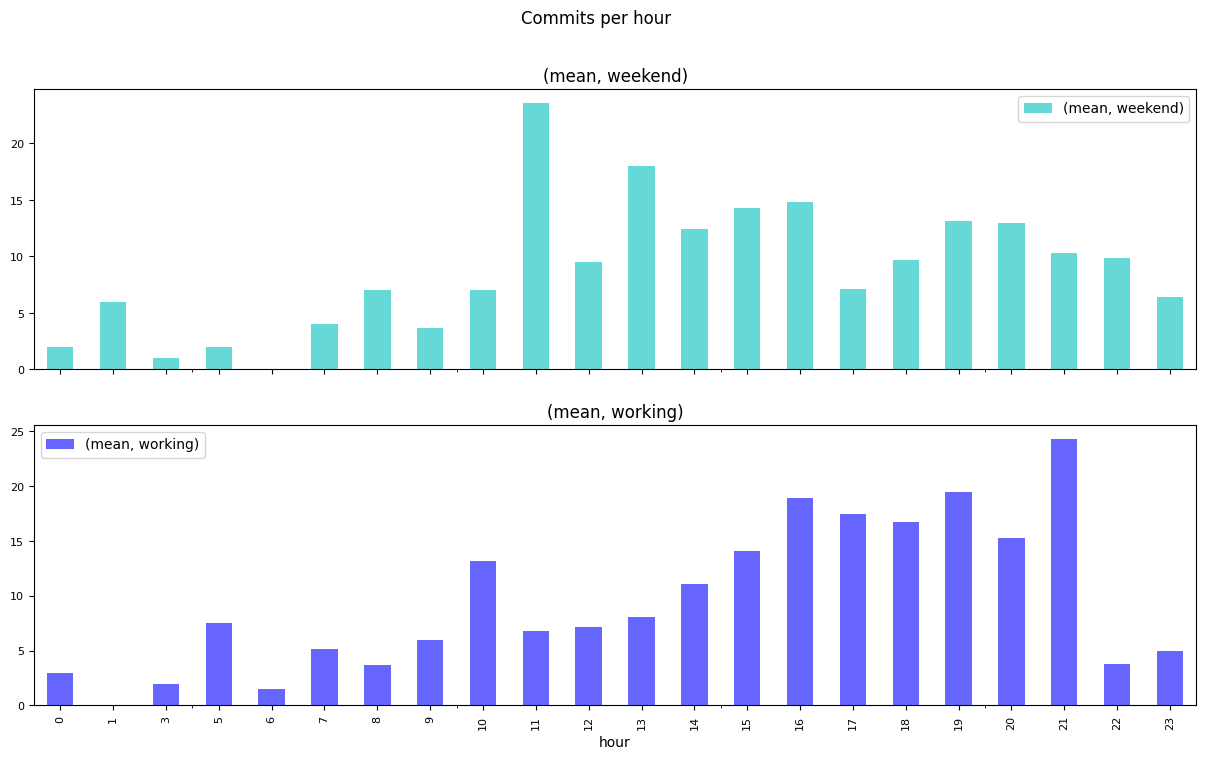

In [7]:
pivot.plot(kind='bar', figsize=(15,8), fontsize=8, title="Commits per hour", rot=90, color=['c','b'],subplots=True, alpha=0.6)

### Is the dynamic different on working days and weekends?

In [8]:
pivot['mean'][pivot['mean']['weekend']==pivot['mean']['weekend'].max()]

day_status,weekend,working
hour,,
11,23.6,6.769231


In [9]:
pivot['mean'][pivot['mean']['working']==pivot['mean']['working'].max()]

day_status,weekend,working
hour,,
21,10.285714,24.333333


### conclusion: the majority of people who make commits on weekdays prefer to do it at 21, whereas people who decided to make commits on weekends usually do it at 20

In [10]:
connect.close()